# Quality Control

This notebook is for validating the drought indices dataset produced using the `scripts/process.py` script.

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from config import INDICES_DIR, DOWNLOAD_DIR, CLIM_DIR
import luts
from scripts.snap.process_calibration_params import estimate_params
from xclim.indices.stats import dist_method
from scipy.ndimage import gaussian_filter

## Index validation

For each drought index, re-compute a value manually and compare with the corresponding value extracted from the indices dataset.

We will be working with the climatologies, the downloaded ERA5 data, and of course the computed indices data. We will be accessing the indices dataset for each check, so we will set up a global connection to this dataset... which is actually a set of netCDF files for each interval, so we can open them as one dataset using `xarray.open_mfdataset`:

In [2]:
intervals = pd.Index([1, 7, 30, 60, 90, 180, 365], name="interval")
fps = [INDICES_DIR.joinpath(f"nws_drought_indices_{i}day.nc") for i in intervals]
indices_ds = xr.open_mfdataset(fps, combine="nested", concat_dim=[intervals])

# also get the refernce date, 
ref_date = pd.to_datetime(indices_ds.attrs["reference_date"])

Define a function to help with extracting data from grid cells in ERA5 downloads, since we will be doing this for every index as well. Note, we should have the precomputed "combined" ERA5 dataset as well, since it is written to disk during the main processing, but we will just include the merge+concatting here again. 

Also define other functions that will help.

In [3]:
def extract_era5(index, time_slice, lat, lon):
    """Function to open the three ERA5 datasets for a given variable name and extract the data from a grid cell for a given point location"""
    varname_lu = {
        "tp": "tp",
        "pntp": "tp",
        "swe": "sd",
        "pnswe": "sd",
        "spi": "tp",
        "smd1": "swvl1",
        "smd2": "swvl2",
        "pev": "pev"
    }
    varname = varname_lu[index]
    da_list = []
    latlon_sel_di = {"latitude": lat, "longitude": lon}
    for fp in DOWNLOAD_DIR.glob(f"{luts.varname_prefix_lu[varname]}*.nc"):
        with xr.open_dataset(fp) as ds:
            if "expver" in ds.dims:
                # if expver is present, combine from both into a single dataset and drop it
                da = xr.merge([
                    ds[varname].sel(
                        latlon_sel_di, method="nearest"
                    ).sel(expver=1).drop("expver"),
                    ds[varname].sel(
                        latlon_sel_di, method="nearest"
                    ).sel(expver=5).drop("expver")
                ])[varname].sel(time=time_slice)

            else:
                da = ds[varname].sel(
                    latlon_sel_di, method="nearest"
                ).sel(time=time_slice)

            da_list.append(da)
            
    out_da = xr.concat(da_list, dim="time").sortby("time")
    return out_da


# function to extract from the climatology datasets
def extract_clim(varname, doy_list, lat, lon):
    clim_lu = {
        "tp": "era5_daily_tp_climatology_1981_2020_leap.nc",
        "swe": "era5_swe_climo_81-20.nc",
        "swvl": "era5_daily_swvl_1981_2020.nc"
    }
    with xr.open_dataset(CLIM_DIR.joinpath(clim_lu[varname])) as clim_ds:
        
        # need to re-index longitude in some cases, not consistent across clim datasets
        if clim_ds.longitude.values[0] == 180:
            clim_ds = clim_ds.assign_coords(
                longitude=(clim_ds.longitude.values) - 360
            )
        # same reason as above, inconsistency between clims... reindex coords with dayofyear
        try:
            if clim_ds.time.dt.year.values[0] == 1980:
                clim_ds = clim_ds.assign_coords(
                    time=clim_ds.time.dt.dayofyear
                )
        except TypeError:
            pass

        clim_da = clim_ds[varname].sel(time=doy_list).sel(
            latitude=lat, longitude=lon, method="nearest"
        )

    return clim_da

    
def get_time_slice(ref_date, interval):
    start_date = ref_date - pd.to_timedelta(f"{interval - 1} day")
    return slice(start_date.strftime("%Y-%m-%d"), ref_date.strftime("%Y-%m-%d"))

# generate list of day-of-year values corresponding to the interval window and reference date
def get_doy_list(ref_date, interval):
    ref_doy = ref_date.timetuple().tm_yday
    start_doy = ref_doy - (interval - 1)
    if start_doy < 1:
        second_start = 365 - (-start_doy)
        doys = list(
            np.arange(1, ref_doy + 1)
        ) + list(np.arange(second_start, 367))
    else:
        doys = list(np.arange(start_doy, ref_doy + 1))
    return doys


# function to extract from indices dataset
def get_test_value(index, interval, latlon_sel_di):
    return indices_ds[index].sel(interval=interval).sel(
        **latlon_sel_di
    ).compute()

### Strategy

Okay the gameplan here will be to define a function that checks some index (or index precursor in the case of SPI and SPEI gamma parameters) for some global lat/lon and interval. Using some globals here because it just seems superflous to do things like e.g. pass the indices dataset object to every single fucntion..

We will define the functions, and then iterate over some coordinate and interval combinations and compare against extractions from existing data. Some functions **will return some output** for use in other functions where there are useful dependencies.

In [4]:
def check_tp():
    index = "tp"
    test = get_test_value(index, interval, latlon_sel_di)
    raw = extract_era5("tp", time_slice, lat, lon)
    # convert m to cm
    check = np.round((raw.sum() * 100).astype("float32"), 1)
    # save value for pntp check
    tp_check = check
    assert check == test
    
    return tp_check


def check_pntp(tp_check):
    index = "pntp"
    test = get_test_value(index, interval, latlon_sel_di)
    clim = extract_clim("tp", doy_list, lat, lon)
    check = np.round(((tp_check / clim.sum()) * 100).astype("float32"), 1)
    
    assert check == test
    
    
def check_swe():
    index = "swe"
    test = get_test_value(index, interval, latlon_sel_di)
    raw = extract_era5(index, time_slice, lat, lon)
    check = np.round((raw.mean() * 100).astype("float32"), 1)
    swe_check = check
    assert check == test
    
    return swe_check


def check_pnswe(swe_check):
    index = "pnswe"
    test = get_test_value(index, interval, latlon_sel_di)
    clim = extract_clim("swe", doy_list, lat, lon)
    check = np.round((swe_check / (clim.mean())), 1).astype("float32")

    assert check == test
    
    
def check_smd():
    index = "smd"
    test = get_test_value(index, interval, latlon_sel_di)
    # two different extractions since we are working with two different 
    #  levels here
    raw1 = extract_era5(index + "1", time_slice, lat, lon)
    raw2 = extract_era5(index + "2", time_slice, lat, lon)
    #combine the levels
    raw = (raw1 * 0.25) + (raw2 * 0.75)
    clim = extract_clim("swvl", doy_list, lat, lon)
    check = np.round((((clim.mean() - raw.mean()) / clim.mean()) * 100).astype("float32"), 1)

    assert check == test
    
    
# Okay for these two indices we need to do little bit more checking.
# We have precursor datasets for the estimated parameters of gamma distributions fitted
#  to the daily precip data over the historical period, which are akin to the climatologies,
#  and we want to check these too.
# We have the daily precip and pev files at 
# `/workspace/Shared/Tech_Projects/NWS_Drought_Indicators/project_data/calibration/`. 
# We will first validate these estimated parameters by recomputing them from the daily data.

def check_spi_params():
    # copied from /workspace/Shared/Tech_Projects/NWS_Drought_Indicators/project_data/calibration
    cal_dir = Path("/atlas_scratch/kmredilla/nws_drought_indicators/calibration/")
    tp_daily_fp = cal_dir.joinpath("era5_daily_tp_1981_2020.nc")
    daily_tp_ds = xr.open_dataset(tp_daily_fp)
    daily_tp = daily_tp_ds["tp"].sel(**latlon_sel_di)
    spi_params = estimate_params(daily_tp, interval)
    check = spi_params.sel(dayofyear=ref_doy).astype("float32")

    with xr.open_dataset(CLIM_DIR.joinpath("spi_gamma_parameters.nc")) as spi_ds:
        test = spi_ds["params"].sel(**latlon_sel_di).sel(
            interval=interval, dayofyear=ref_doy
        )

    assert np.all(check == test)
    return daily_tp, spi_params


def check_spei_params(daily_tp):
    # copied from /workspace/Shared/Tech_Projects/NWS_Drought_Indicators/project_data/calibration
    cal_dir = Path("/atlas_scratch/kmredilla/nws_drought_indicators/calibration/")
    pev_daily_fp = cal_dir.joinpath("era5_daily_pev_1981_2020.nc")
    daily_pev_ds = xr.open_dataset(pev_daily_fp)
    daily_pev = daily_pev_ds["pev"].sel(latitude=lat, longitude=lon, method="nearest")
    daily_wb = daily_tp + daily_pev
    daily_wb += 0.002
    spei_params = estimate_params(daily_wb, interval)
    check = spei_params.sel(dayofyear=ref_doy).astype("float32")

    with xr.open_dataset(CLIM_DIR.joinpath("spei_gamma_parameters.nc")) as spei_ds:
        test = spei_ds["params"].sel(**latlon_sel_di).sel(
            interval=interval, dayofyear=ref_doy
        )

    assert np.all(check == test)
    return spei_params



# These two fucntions are for validating the SPI and SPEI indices themselves,
#  and will use the validated parameter estimates

def check_spi(spi_params):
    index = "spi"
    test = get_test_value(index, interval, latlon_sel_di)
    raw_tp = extract_era5("tp", time_slice, lat, lon)
    pr = raw_tp.resample(time="1D").sum().mean()
    spi_params.attrs["scipy_dist"] = "gamma"

    # do the statistical parts
    prob = dist_method(
        "cdf",
        spi_params.sel(dayofyear=ref_doy).astype("float32"),
        pr.where(pr > 0)
    )
    params_norm = xr.DataArray(
        [0, 1],
        dims=["dparams"],
        coords=dict(dparams=(["loc", "scale"])),
        attrs=dict(scipy_dist="norm"),
    )
    check = np.round(dist_method("ppf", params_norm, prob), 1)

    assert check == test
    return raw_tp


def check_spei(raw_tp, spei_params):
    index = "spei"
    test = get_test_value(index, interval, latlon_sel_di)
    raw_pev = extract_era5("pev", time_slice, lat, lon)
    wb = (raw_tp + raw_pev).resample(time="1D").sum().mean()
    wb += 0.002
    spei_params.attrs["scipy_dist"] = "gamma"

    # do the statistical parts
    prob = dist_method(
        "cdf",
        spei_params.sel(dayofyear=ref_doy).astype("float32"),
        wb.where(wb > 0)
    )
    params_norm = xr.DataArray(
        [0, 1],
        dims=["dparams"],
        coords=dict(dparams=(["loc", "scale"])),
        attrs=dict(scipy_dist="norm"),
    )
    check = np.round(dist_method("ppf", params_norm, prob), 1)

    assert check == test

Okay, now the magic hopefully happens. Iterate over some combinations of intervals and point locations and fun all of the functions that do the checks. If no AssertionErrors occur, then the checks all pass.

In [5]:
%%time
intervals = [7, 30, 60, 90, 180, 365]
coords =  ((65, -148), (61, -150), (58, -134), (71, -157))
ref_doy = ref_date.timetuple().tm_yday
for interval in intervals:
    time_slice = get_time_slice(ref_date, interval)
    doy_list = get_doy_list(ref_date, interval)
    for coord in coords:
        lat, lon = coord
        latlon_sel_di = {"latitude": lat, "longitude": lon, "method": "nearest"}
        tp_check = check_tp()
        check_pntp(tp_check)
        swe_check = check_swe()
        check_pnswe(swe_check)
        check_smd()
        daily_tp, spi_params = check_spi_params()
        spei_params = check_spei_params(daily_tp)
        raw_tp = check_spi(spi_params)
        check_spei(raw_tp, spei_params)

CPU times: user 1min 9s, sys: 17.9 s, total: 1min 27s
Wall time: 1min 36s


#### 1-Day indices

Last we will check the 1-day interval for the SMD and SWE indices. These use a gaussian filter to smooth the daily data, so we will make ERA5 extractions of 30 days and smooth them before using the most recent of those values.

Define some functions to do the checking, like above:

In [6]:
def check_swe_1d():
    index = "swe"
    test = get_test_value(index, interval, latlon_sel_di)
    
    raw = extract_era5(index, time_slice, lat, lon)
    smooth_1d = gaussian_filter(raw.resample(time="1D").mean(), sigma=(2))[-1]
    check = np.round(smooth_1d * 100, 1).astype("float32")
    
    assert check == test
    
    
def check_smd_1d():
    index = "smd"
    test = get_test_value(index, interval, latlon_sel_di)
     
    raw1 = extract_era5(index + "1", time_slice, lat, lon)
    raw2 = extract_era5(index + "2", time_slice, lat, lon)
    #combine the levels
    raw = (raw1 * 0.25) + (raw2 * 0.75)
    smooth_1d = gaussian_filter(raw.resample(time="1D").mean(), sigma=(2))[-1]
    clim = extract_clim("swvl", doy, lat, lon)
    check = np.round((((clim - smooth_1d) / clim) * 100).astype("float32"), 1)
    
    assert check == test

We will also define a function to check that values for the other indices are consistently NaN for this interval, because it is only defined for these two indices:

In [7]:
def check_indices_are_nan():
    for index in ["tp", "pnswe", "pntp", "spi", "spei"]:
        test = get_test_value(index, interval, latlon_sel_di)
        assert np.isnan(test)

Then run the checks for all coordinates:

In [8]:
%%time

# our time slice will be for the 30 days needed to smooth the data
time_slice = get_time_slice(ref_date, 30)
doy = get_doy_list(ref_date, 1)
interval = 1

for coord in coords:
    lat, lon = coord
    latlon_sel_di = {"latitude": lat, "longitude": lon, "method": "nearest"}
    check_swe_1d()
    check_smd_1d()
    check_indices_are_nan()

CPU times: user 988 ms, sys: 703 ms, total: 1.69 s
Wall time: 1.7 s


### Histograms

Here we will just do a general histogram-based quality check of the data to make sure things look okay. Simply generate histograms of all the data for each index:

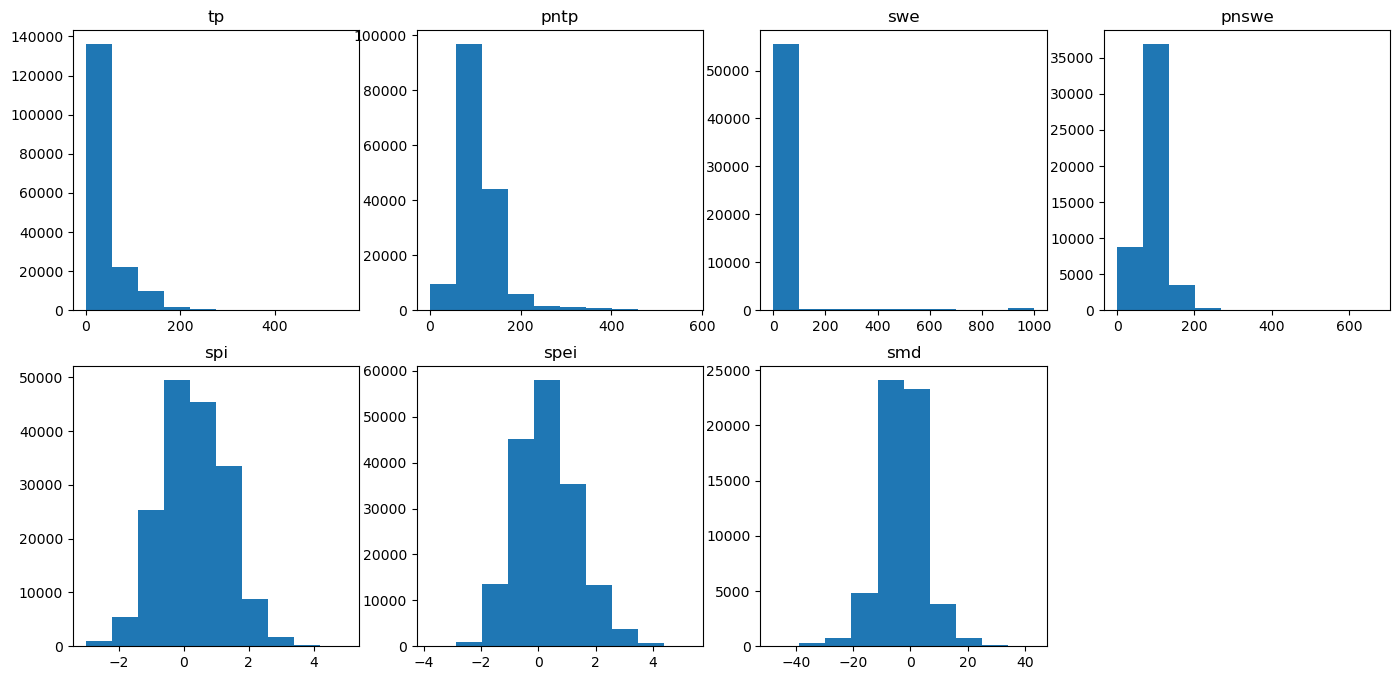

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(17,8))
for varname, ax in zip(list(indices_ds.data_vars) + [None], axs.flatten()):
    try:
        ax.hist(indices_ds[varname].values.flatten())
        ax.set_title(varname)
    except KeyError:
        ax.axis("off")

We should expect to see normalish looking distributions for SPEI and SPI. SMD should probably be something symmetricish, since it is a deficit, we would expect to see both positive and negative values, probably between -100 and 100. We should expect distributions that are bounded on the left by zero, and long-tailed to the right for the water indices: TP, PNTP, SWE, and PNSWE. Maximum values for these should all probably be below 1000 to 1500, with the percent of normal indices probably being higher in general.